# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.



## Utility Functions

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# TODO add some error handling for file not found...etc...
def open_image(path):
    image = mpimg.imread(path)
    return np.copy(image)

def display_image(image, cmap=''):
    if cmap:
        plt.imshow(image,cmap)
    else:
        plt.imshow(image)
    plt.show()
    
def draw_final_image(img, lines, color=[255, 0, 0], thickness=5):
    """
    Improved draw_lines function
    """
    #Good middle of the lane value
    middle = 500
    left_lines = []
    right_lines = []
    #separate out lane lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < middle and x2 < middle:
                left_lines.append(line)
            if x1 > middle and x2 > middle:
                right_lines.append(line)
            
    #do a polyfit on lines.  This is affectively finding the average slope
    x = []
    y = []
    for line in left_lines:
        for x1, y1, x2, y2 in line:
            x +=[x1, x2]
            y +=[y1, y2]
    left_poly = np.polyfit(x, y, 1)
    
    a = []
    b = []
    for line in right_lines:
        for x1, y1, x2, y2 in line:
            a +=[x1, x2]
            b +=[y1, y2]
            
    right_poly = np.polyfit(a, b, 1)
    
    #Use the orignal shape dimensions to extrapolate.  Find the x1, x2 and y1, y2 using the slope found during the polyfit
    
    
    y1 = img.shape[1]
    x1 = int((y1 - left_poly[1])/(left_poly[0]))
    y2 = min(y)
    x2 = int((y2 - left_poly[1])/(left_poly[0]))
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    y1 = img.shape[1]
    x1 = int((y1 - right_poly[1])/(right_poly[0]))
    y2 = min(y)
    x2 = int((y2 - right_poly[1])/(right_poly[0]))
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)


In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_final_image(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Color Select Function

In [3]:
def color_select_image(color_select, display=False):
    
    
    #2 convert to hls
    hsl = cv2.cvtColor(color_select,cv2.COLOR_RGB2HLS)
    #3 establish white threshold
    lower_white = np.array([0,180,0])
    upper_white = np.array([255,255,255])
    #4 produce white mask
    white_mask = cv2.inRange(hsl, lower_white, upper_white)
    #5 establish yellow threshold
    lower_yellow = np.array([4,0,100])
    upper_yellow = np.array([40,255,255])
    #6 produce yellow mask
    yellow_mask = cv2.inRange(hsl, lower_yellow, upper_yellow)
    #7 or together white an yellow mask
    white_yellow_mask = cv2.bitwise_or(white_mask, yellow_mask)
    #8 and white/yellow mask with original frame
    new_image = cv2.bitwise_and(color_select, color_select, mask = white_yellow_mask)
    if display:
        display_image(new_image)
    return new_image

## Find Region of Interest

In [4]:
def find_region_of_interest(img, display=False):
    #1 define corners
    numb_rows, numb_col = img.shape[:2]
    bot_left  =  [numb_col * 0.1, numb_rows * 1.0]
    bot_right =  [numb_col * 1.0, numb_rows * 1.0]
    top_left  =  [numb_col * 0.44, numb_rows * 0.6]
    top_right =  [numb_col * 0.54, numb_rows * 0.6]
    
    corners = np.array([bot_left, top_left, top_right, bot_right], dtype=np.int32)
    new_image = region_of_interest(img, [corners])
    if display:
        display_image(new_image)
    return new_image

## Gauss image

In [5]:
def gaussian_image(img, kernel_size, display=False):
    new_image = gaussian_blur(img,kernel_size)
    if display:
        display_image(new_image)
    return new_image

## Canny

In [6]:
def canny_image(img, low_threshold, high_threshold, display=False):
    gray_image = grayscale(img)
    new_image = canny(gray_image, low_threshold, high_threshold)
    if display:
        display_image(new_image, cmap="Greys_r")
    return new_image

## Hough Image

In [7]:
def hough_image(img):
    rho = 1
    theta = np.pi/180 
    threshold = 10
    min_line_length = 10
    max_line_gap = 100
    
    return hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap)

In [8]:
def image_pipeline(path, display=False):
    """
    Pipeline has the following stages
    1. Select both white and yellow
    """
    
    image = open_image(path)
    
    color_image = color_select_image(image, display)
    region_select_image = find_region_of_interest(color_image, display)
    guassimage = gaussian_image(region_select_image,5, display)
    cannyimage = canny_image(guassimage, 75, 150, display)
    houghlines = hough_image(cannyimage)
    return weighted_img(houghlines, open_image(path))
    
    
    
    

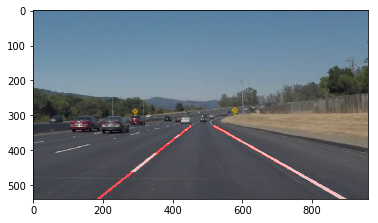

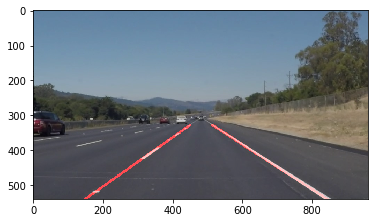

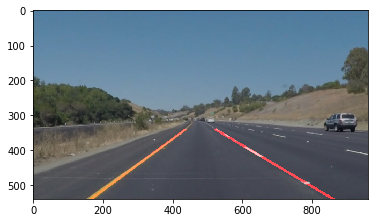

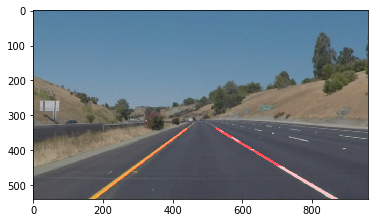

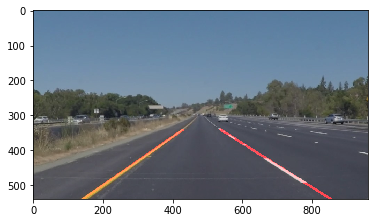

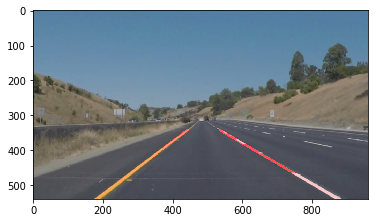

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import os

test_image_dir = os.getcwd() + "/test_images/"
test_output_dir = os.getcwd() + "/test_images_output/"

file_list = os.listdir(test_image_dir)

for image_file in file_list:
    #image = image_pipeline(test_image_dir + image_file, image_file == 'solidWhiteRight.jpg')
    image = image_pipeline(test_image_dir + image_file)
    display_image(image)
    mpimg.imsave(test_output_dir + os.path.basename(image_file) + ".png", image)


In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    color_image = color_select_image(image)
    region_select_image = find_region_of_interest(color_image)
    guassimage = gaussian_image(region_select_image,5)
    cannyimage = canny_image(guassimage, 75, 150)
    houghlines = hough_image(cannyimage)
    return weighted_img(houghlines, image)
    
    

In [12]:
white_output = os.getcwd() + "/test_videos_output/solidWhiteRight.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(os.getcwd() + "/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidWhiteRight.mp4 

CPU times: user 24.5 s, sys: 113 ms, total: 24.6 s
Wall time: 12 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
yellow_output = os.getcwd() + "/test_videos_output/solidYellowLeft.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip(os.getcwd() + "/test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:36<00:00, 17.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/hbutler/udacity/Finding-Lane-Lines/test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 14s, sys: 593 ms, total: 1min 14s
Wall time: 37.4 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))